<a href="https://colab.research.google.com/github/Dmitry1937/TF/blob/main/C4W1_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 1 Assignment: Neural Style Transfer

Welcome to the first programming assignment of this course! Here, you will be implementing neural style transfer using the [Inception](https://arxiv.org/abs/1512.00567v3) model as your feature extractor. This is very similar to the Neural Style Transfer ungraded lab so if you get stuck, remember to review the said notebook for tips.

***Important:*** *This colab notebook has read-only access so you won't be able to save your changes. If you want to save your work periodically, please click `File -> Save a Copy in Drive` to create a copy in your account, then work from there.*  

## Imports

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K

from imageio import mimsave
from IPython.display import display as display_fn
from IPython.display import Image, clear_output

## Utilities

As before, we've provided some utility functions below to help in loading, visualizing, and preprocessing the images.

In [ ]:
def tensor_to_image(tensor):
  '''converts a tensor to an image'''
  tensor_shape = tf.shape(tensor)
  number_elem_shape = tf.shape(tensor_shape)
  if number_elem_shape > 3:
    assert tensor_shape[0] == 1
    tensor = tensor[0]
  return tf.keras.preprocessing.image.array_to_img(tensor) 


def load_img(path_to_img):
  '''loads an image as a tensor and scales it to 512 pixels'''
  max_dim = 512
  image = tf.io.read_file(path_to_img)
  image = tf.image.decode_jpeg(image)
  image = tf.image.convert_image_dtype(image, tf.float32)

  shape = tf.shape(image)[:-1]
  shape = tf.cast(tf.shape(image)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  image = tf.image.resize(image, new_shape)
  image = image[tf.newaxis, :]
  image = tf.image.convert_image_dtype(image, tf.uint8)

  return image


def load_images(content_path, style_path):
  '''loads the content and path images as tensors'''
  content_image = load_img("{}".format(content_path))
  style_image = load_img("{}".format(style_path))

  return content_image, style_image


def imshow(image, title=None):
  '''displays an image with a corresponding title'''
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)
    
    
def show_images_with_objects(images, titles=[]):
  '''displays a row of images with corresponding titles'''
  if len(images) != len(titles):
    return

  plt.figure(figsize=(20, 12))
  for idx, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1, len(images), idx + 1)
    plt.xticks([])
    plt.yticks([])
    imshow(image, title)


def clip_image_values(image, min_value=0.0, max_value=255.0):
  '''clips the image pixel values by the given min and max'''
  return tf.clip_by_value(image, clip_value_min=min_value, clip_value_max=max_value)


def preprocess_image(image):
  '''preprocesses a given image to use with Inception model'''
  image = tf.cast(image, dtype=tf.float32)
  image = (image / 127.5) - 1.0

  return image

## Download Images

You will fetch the two images you will use for the content and style image.

In [ ]:
content_path = tf.keras.utils.get_file('content_image.jpg','https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/dog1.jpg')
style_path = tf.keras.utils.get_file('style_image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

204800/195196 [===============================] - 0s 0us/step


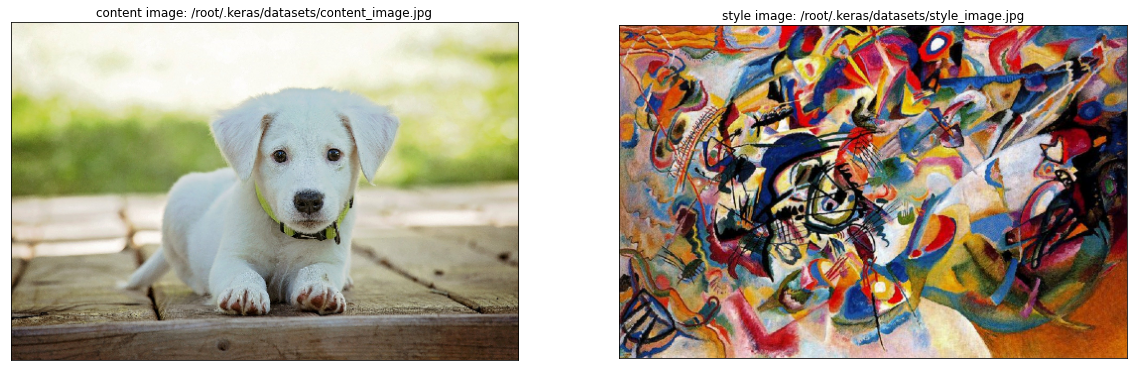

In [ ]:
# display the content and style image
content_image, style_image = load_images(content_path, style_path)
show_images_with_objects([content_image, style_image], 
                         titles=[f'content image: {content_path}',
                                 f'style image: {style_path}'])

## Build the feature extractor

Next, you will inspect the layers of the Inception model.

In [ ]:
# clear session to make layer naming consistent when re-running this cell
K.clear_session()

# download the inception model and inspect the layers
tmp_inception = tf.keras.applications.InceptionV3()
tmp_inception.summary()

# delete temporary model
del tmp_inception

96124928/96112376 [==============================] - 2s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)           

As you can see, it's a very deep network and compared to VGG-19, it's harder to choose which layers to choose to extract features from. 

- Notice that the Conv2D layers are named from `conv2d`, `conv2d_1` ... `conv2d_93`, for a total of 94 conv2d layers.
  - So the second conv2D layer is named `conv2d_1`.
- For the purpose of grading, please choose the following
  - For the content layer: choose the Conv2D layer indexed at `88`.
  - For the style layers, please choose the first `five` conv2D layers near the input end of the model.
    - Note the numbering as mentioned in these instructions.

Choose intermediate layers from the network to represent the style and content of the image:


In [ ]:

# choose the content layer and put in a list
content_layers = ['conv2d_88']

# choose the five style layers of interest
style_layers = ['conv2d','conv2d_1','conv2d_2','conv2d_3','conv2d_4']
                
# combine the content and style layers into one list
content_and_style_layers = style_layers + content_layers

# count the number of content layers and style layers.
# you will use these counts later in the assignment
NUM_CONTENT_LAYERS = len(content_layers)
NUM_STYLE_LAYERS = len(style_layers)

You can now setup your model to output the selected layers.


In [ ]:
def inception_model(layer_names):
  """ Creates a inception model that returns a list of intermediate output values.
    args:
    layer_names: a list of strings, representing the names of the desired content and style layers
    
  returns:
    A model that takes the regular inception v3 input and outputs just the content and style layers.
  
  """
  
  # Load InceptionV3 with the imagenet weights and **without** the fully-connected layer at the top of the network
  inception = tf.keras.applications.InceptionV3(include_top = False,  weights='imagenet')

  # Freeze the weights of the model's layers (make them not trainable)
  inception.trainable = False

  # Create a list of layer objects that are specified by layer_names
  output_layers = [inception.get_layer(layer).output for layer in layer_names]

  # Create the model that outputs the content and style layers
  model = tf.keras.Model(inputs = inception.input, outputs = output_layers)
    
  # return the model
  return model



Create an instance of the content and style model using the function that you just defined

In [ ]:
K.clear_session()


inception = inception_model(content_and_style_layers)


87924736/87910968 [==============================] - 2s 0us/step


## Calculate style loss

The style loss is the average of the squared differences between the features and targets.

In [ ]:
def get_style_loss(features, targets):
  """Expects two images of dimension h, w, c
  
  Args:
    features: tensor with shape: (height, width, channels)
    targets: tensor with shape: (height, width, channels)

  Returns:
    style loss (scalar)
  """

    
  # Calculate the style loss
  style_loss = tf.reduce_mean(tf.square(features - targets))
    

  return style_loss

## Calculate content loss

Calculate the sum of the squared error between the features and targets, then multiply by a scaling factor (0.5).

In [ ]:
def get_content_loss(features, targets):
  """Expects two images of dimension h, w, c
  
  Args:
    features: tensor with shape: (height, width, channels)
    targets: tensor with shape: (height, width, channels)
  
  Returns:
    content loss (scalar)
  """
  # get the sum of the squared error multiplied by a scaling factor
  content_loss = 0.5 * tf.reduce_mean(tf.square(features - targets))
    
  return content_loss

## Calculate the gram matrix

Use `tf.linalg.einsum` to calculate the gram matrix for an input tensor.
- In addition, calculate the scaling factor `num_locations` and divide the gram matrix calculation by `num_locations`.

$$ \text{num locations} = height \times width $$

In [ ]:
def gram_matrix(input_tensor):
  """ Calculates the gram matrix and divides by the number of locations
  Args:
    input_tensor: tensor of shape (batch, height, width, channels)
    
  Returns:
    scaled_gram: gram matrix divided by the number of locations
  """

  # calculate the gram matrix of the input tensor
  gram = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor) 

  # get the height and width of the input tensor
  input_shape = tf.shape(input_tensor) 
  height = input_shape[1] 
  width = input_shape[2] 

  # get the number of locations (height times width), and cast it as a tf.float32
  num_locations = tf.cast(height * width, tf.float32)

  # scale the gram matrix by dividing by the number of locations
  scaled_gram = gram / num_locations
    
  return scaled_gram

## Get the style image features

Given the style image as input, you'll get the style features of the inception model that you just created using `inception_model()`.
- You'll first preprocess the image using the given `preprocess_image` function.
- You'll then get the outputs of the model.
- From the outputs, just get the style feature layers and not the content feature layer.

You can run the following code to check the order of the layers in your inception model:

In [ ]:
tmp_layer_list = [layer.output for layer in inception.layers]
#tmp_layer_list

- For each style layer, calculate the gram matrix.  Store these results in a list and return it.

In [ ]:
def get_style_image_features(image):  
  """ Get the style image features
  
  Args:
    image: an input image
    
  Returns:
    gram_style_features: the style features as gram matrices
  """

  # preprocess the image using the given preprocessing function
  preprocessed_style_image = preprocess_image(image)

  # get the outputs from the inception model that you created using inception_model()
  outputs = inception(preprocessed_style_image)

  # Get just the style feature layers (exclude the content layer)
  style_outputs = outputs[:NUM_STYLE_LAYERS]

  # for each style layer, calculate the gram matrix for that layer and store these results in a list
  gram_style_features = [gram_matrix(input_tensor) for input_tensor in style_outputs]

  return gram_style_features

## Get content image features

You will get the content features of the content image.
- You can follow a similar process as you did with `get_style_image_features`.
- For the content image, you will not calculate the gram matrix of these style features.

In [ ]:
def get_content_image_features(image):
  """ Get the content image features
  
  Args:
    image: an input image
    
  Returns:
    content_outputs: the content features of the image
  """


  # preprocess the image
  preprocessed_content_image = preprocess_image(image)
    
  # get the outputs from the inception model
  outputs = inception(preprocessed_content_image)

  # get the content layer of the outputs
  content_outputs = outputs[NUM_STYLE_LAYERS:]


  return content_outputs

## Calculate the total loss

Please define the total loss using the helper functions you just defined. As a refresher, the total loss is given by $L_{total} = \beta L_{style} + \alpha L_{content}$, where $\beta$ and $\alpha$ are the style and content weights, respectively.


In [ ]:
def get_style_content_loss(style_targets, style_outputs, content_targets, 
                           content_outputs, style_weight, content_weight):
  """ Combine the style and content loss
  
  Args:
    style_targets: style features of the style image
    style_outputs: style features of the generated image
    content_targets: content features of the content image
    content_outputs: content features of the generated image
    style_weight: weight given to the style loss
    content_weight: weight given to the content loss

  Returns:
    total_loss: the combined style and content loss

  """
    
  # Sum of the style losses
  style_loss = tf.add_n([ get_style_loss(style_output, style_target)
                           for style_output, style_target in zip(style_outputs, style_targets)])
  
  # Sum up the content losses
  content_loss = tf.add_n([get_content_loss(content_output, content_target)
                           for content_output, content_target in zip(content_outputs, content_targets)])

  # scale the style loss by multiplying by the style weight and dividing by the number of style layers
  style_loss =  style_loss * style_weight / NUM_STYLE_LAYERS

  # scale the content loss by multiplying by the content weight and dividing by the number of content layers
  content_loss = content_loss * content_weight / NUM_CONTENT_LAYERS
    
  # sum up the style and content losses
  total_loss = style_loss +  content_loss

  # return the total loss
  return total_loss

## Calculate gradients

Please use `tf.GradientTape()` to get the gradients of the loss with respect to the input image. Take note that you will *not* need a regularization parameter in this exercise so we only provided the style and content weights as arguments.

In [ ]:
def calculate_gradients(image, style_targets, content_targets, 
                        style_weight, content_weight):
  """ Calculate the gradients of the loss with respect to the generated image
  Args:
    image: generated image
    style_targets: style features of the style image
    content_targets: content features of the content image
    style_weight: weight given to the style loss
    content_weight: weight given to the content loss
  
  Returns:
    gradients: gradients of the loss with respect to the input image
  """

  with tf.GradientTape() as tape:
      
    # get the style image features
    style_features = get_style_image_features(image)
    # get the content image features
    content_features = get_content_image_features(image)
      
    # get the style and content loss
    loss = get_style_content_loss(style_targets, style_features, content_targets, 
                           content_features, style_weight, content_weight)

  # calculate gradients of loss with respect to the image
  gradients = tape.gradient(loss,image)


  return gradients

## Update the image with the style

Please define the helper function to apply the gradients to the generated/stylized image.

In [ ]:
def update_image_with_style(image, style_targets, content_targets, style_weight, 
                            content_weight, optimizer):
  """
  Args:
    image: generated image
    style_targets: style features of the style image
    content_targets: content features of the content image
    style_weight: weight given to the style loss
    content_weight: weight given to the content loss
    optimizer: optimizer for updating the input image
  """

  # Calculate gradients using the function that you just defined.
  gradients = calculate_gradients(image, style_targets, content_targets, 
                        style_weight, content_weight)

  # apply the gradients to the given image
  optimizer.apply_gradients([(gradients, image)])

  # Clip the image using the given clip_image_values() function
  image.assign(clip_image_values(image, min_value=0.0, max_value=255.0))

## Generate the stylized image

Please complete the function below to implement neural style transfer between your content and style images.

In [ ]:
def fit_style_transfer(style_image, content_image, style_weight=1e-2, content_weight=1e-4, 
                       optimizer='adam', epochs=1, steps_per_epoch=1):
  """ Performs neural style transfer.
  Args:
    style_image: image to get style features from
    content_image: image to stylize 
    style_targets: style features of the style image
    content_targets: content features of the content image
    style_weight: weight given to the style loss
    content_weight: weight given to the content loss
    optimizer: optimizer for updating the input image
    epochs: number of epochs
    steps_per_epoch = steps per epoch
  
  Returns:
    generated_image: generated image at final epoch
    images: collection of generated images per epoch  
  """

  images = []
  step = 0

  # get the style image features 
  style_targets = get_style_image_features(style_image)
    
  # get the content image features
  content_targets = get_content_image_features(content_image)

  # initialize the generated image for updates
  generated_image = tf.cast(content_image, dtype=tf.float32)
  generated_image = tf.Variable(generated_image) 
  
  # collect the image updates starting from the content image
  images.append(content_image)
  
  for n in range(epochs):
    for m in range(steps_per_epoch):
      step += 1
    
      # Update the image with the style using the function that you defined
      update_image_with_style(generated_image, style_targets, content_targets, style_weight, 
                            content_weight, optimizer)
    

      print(".", end='')
      if (m + 1) % 10 == 0:
        images.append(generated_image)
    
    # display the current stylized image
    clear_output(wait=True)
    display_image = tensor_to_image(generated_image)
    display_fn(display_image)

    # append to the image collection for visualization later
    images.append(generated_image)
    print("Train step: {}".format(step))
  
  # convert to uint8 (expected dtype for images with pixels in the range [0,255])
  generated_image = tf.cast(generated_image, dtype=tf.uint8)
  
  return generated_image, images

With all the helper functions defined, you can now run the main loop and generate the stylized image. This will take a few minutes to run.

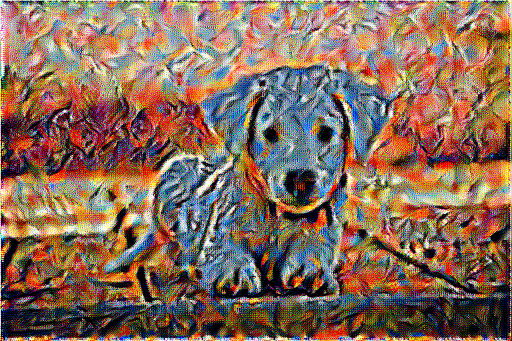

Train step: 1000


In [ ]:


# define style and content weight
style_weight =  1
content_weight = 1e-32 

# define optimizer. learning rate decreases per epoch.
adam = tf.optimizers.Adam(
    tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=80.0, decay_steps=100, decay_rate=0.80
    )
)

# start the neural style transfer
stylized_image, display_images = fit_style_transfer(style_image=style_image, content_image=content_image, 
                                                    style_weight=style_weight, content_weight=content_weight,
                                                    optimizer=adam, epochs=10, steps_per_epoch=100)

When the loop completes, please right click the image you generated and download it for grading in the classroom.

**Congratulations! You just completed the assignment on Neural Style Transfer!**
